In [5]:
import os
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(ROOT)

/home/saisampathkedari/MonteCarlo-Statistical-Methods


In [1]:
from typing import Callable, Tuple
from dataclasses import dataclass
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sympy

In [2]:
from utils.montecarlo import monte_carlo, MonteCarloEstimate
from importance_sampling.importance_sampling import *

## Motivation

In classical importance sampling, we assume the target density \(f_X(x)\) and proposal density \(g(x)\) are known exactly, so the weight  
$$
w(x) = \frac{f_X(x)}{g(x)}
$$
can be evaluated.

However, in many applications the densities are known only up to unknown normalizing constants.  
We may have  
$$
f_X(x) = \frac{\hat{f}_X(x)}{c},
\qquad
g(x) = \frac{\hat{g}(x)}{b},
$$
where \( \hat{f}_X(x) \) and \( \hat{g}(x) \) are known unnormalized forms, but the constants \(c\) and \(b\) are unknown.

This prevents us from forming the classical importance weight  
$$
w(x) = \frac{f_X(x)}{g(x)}.
$$

Self-normalized importance sampling resolves this difficulty by working entirely with unnormalized densities.

---

## Setup

We want to estimate  
$$
p = \mathbb{E}_f[h(X)]
    = \int h(x) f_X(x)\,dx.
$$

Since  
$$
f_X(x) = \frac{\hat{f}_X(x)}{c},
$$
we write  
$$
p = \frac{1}{c}\int h(x)\,\hat{f}_X(x)\,dx.
$$

Insert the proposal representation  
$$
1 = \frac{\hat{g}(x)}{\hat{g}(x)}
$$
and rewrite:
$$
p = 
\frac{1}{c}
\int
h(x)
\hat{f}_X(x)
\frac{\hat{g}(x)}{\hat{g}(x)}\,dx.
$$

Multiply and divide by \(b\):
$$
p =
\frac{b}{c}
\int
h(x)
\frac{\hat{f}_X(x)}{\hat{g}(x)}
\,
\frac{\hat{g}(x)}{b}\,dx.
$$

Since  
$$
g(x) = \frac{\hat{g}(x)}{b},
$$
we obtain  
$$
p =
\frac{b}{c}
\,
\mathbb{E}_g\!\left[ h(X)\,\hat{w}(X) \right],
$$
where the unnormalized weight is  
$$
\hat{w}(x)
=
\frac{\hat{f}_X(x)}{\hat{g}(x)}.
$$

At this point, both \(b\) and \(c\) are unknown.  
To eliminate them, we write an analogous expression for the constant:
$$
1
=
\int f_X(x)\,dx
=
\frac{b}{c}
\int
\frac{\hat{f}_X(x)}{\hat{g}(x)}
\frac{\hat{g}(x)}{b}\,dx
=
\frac{b}{c}
\,
\mathbb{E}_g\!\left[\hat{w}(X)\right].
$$

Solving,
$$
\frac{b}{c}
=
\frac{1}{\mathbb{E}_g[\hat{w}(X)]}.
$$

Substitute into the formula for \(p\):
$$
p
=
\frac{\mathbb{E}_g\!\left[h(X)\hat{w}(X)\right]}
     {\mathbb{E}_g\!\left[\hat{w}(X)\right]}.
$$

Thus the unknown constants cancel entirely.

---

## Self-Normalized Importance Sampling Estimator

Draw  
$$
X_1,\dots,X_n \sim g.
$$

Compute unnormalized weights:
$$
\hat{w}(X_i)
=
\frac{\hat{f}_X(X_i)}{\hat{g}(X_i)}.
$$

Normalize:
$$
\bar{w}(X_i)
=
\frac{\hat{w}(X_i)}{\sum_{j=1}^n \hat{w}(X_j)}.
$$

Define the estimator:
$$
\hat{p}_n^{SNIS}
=
\sum_{i=1}^n 
\bar{w}(X_i)\,h(X_i).
$$

This estimator is computable using only the unnormalized densities.  
The normalizing constants \(c\) and \(b\) never appear.

---

## Interpretation

The distribution \(f_X\) is approximated by the empirical distribution  
$$
\sum_{i=1}^n \bar{w}(X_i)\,\delta_{X_i},
$$
where each sample \(X_i\) contributes mass proportional to \(\hat{f}_X(X_i)/\hat{g}(X_i)\).  
The expectation under \(f_X\) is replaced by the weighted empirical average  
$$
\hat{p}_n^{SNIS}.
$$

The normalization ensures  
$$
\sum_{i=1}^n \bar{w}(X_i) = 1,
$$
so the estimator behaves like an expectation under a probability distribution.

---

## Properties of the SNIS Estimator

The estimator  
$$
\hat{p}_n^{SNIS}
=
\sum_{i=1}^n 
\bar{w}(X_i)\,h(X_i)
$$
has the following properties:

1. **It is not unbiased.**  
   The ratio of random quantities produces a bias that decreases at rate \(1/n\).

2. **It is consistent.**  
   Under standard assumptions,
   $$ 
   \hat{p}_n^{SNIS} \to p
   \quad
   \text{almost surely}.
   $$

3. **Its asymptotic variance can be derived using the delta method.**  
   (We do not derive it here.)

4. **When the target density is known only up to a constant, SNIS is the standard and necessary estimator.**

These properties make SNIS essential in Bayesian inference, filtering, and any setting where normalizing constants are unavailable.


# Example

## Bayesian Model and Data Generation

We begin with a simple Bayesian model that produces a non-conjugate posterior, making self-normalized importance sampling (SNIS) necessary.

We observe data  
$$
X_1,\dots,X_n \mid \theta \sim \mathcal{N}(\theta,1),
$$
and we place a Laplace prior with scale parameter $\lambda = 1$:
$$
\pi(\theta) = \frac{1}{2} e^{-|\theta|}.
$$

We fix a true parameter value $\theta^\star = 2$ and generate $n$ observations:


In [3]:
true_theta = 2 # This is unknown to us, we are just generating sample using this
sigma = 1.0
samples_normal = sigma * np.random.randn(10) + true_theta

#### lets see how the prior, data generated likelihood gonna look like

In [4]:
# Laplace Distribution as Prior with loc = 0, scale = lambda_param
lambda_param = 1
prior_rv = stats.laplace(loc=0, scale=lambda_param)

# Standard Normal Distribution for likelihood
likelihood_rv = stats.norm(loc=true_theta, scale=sigma)

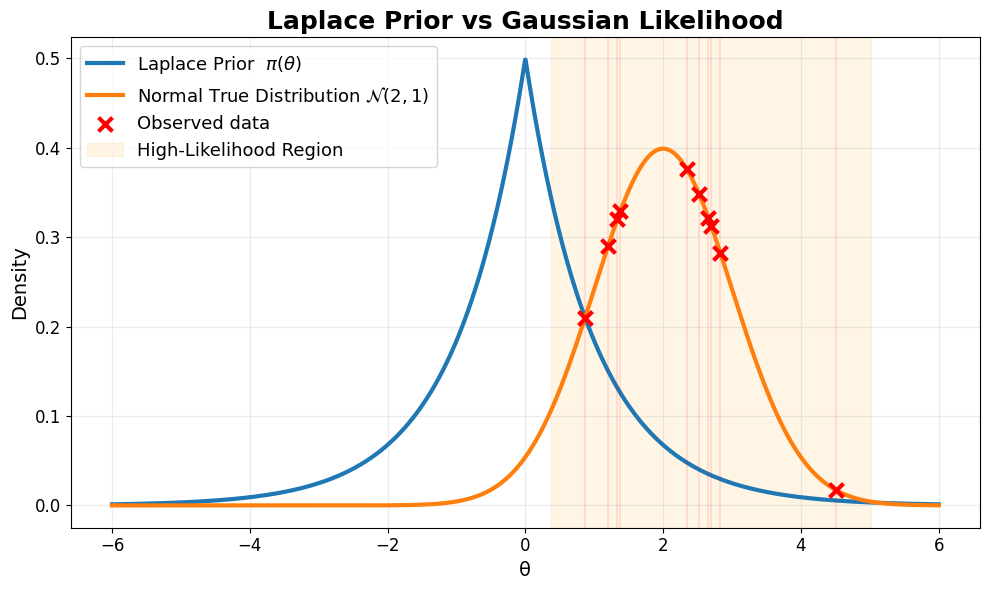

In [6]:
# Lets plot both prior and Likelihood
x = np.linspace(-6, 6, 2000)
prior_pdf = prior_rv.pdf(x)
likelihood_pdf = likelihood_rv.pdf(x)

# Compute likelihood of the data generated with true mean
samples_likelihood = likelihood_rv.pdf(samples_normal)

# plotting
plt.figure(figsize=(10,6))
plt.plot(x, prior_pdf, label ="Laplace Prior  $\\pi(\\theta)$", linewidth=3, color="#1f77b4")
plt.plot(x, likelihood_pdf, label = "Normal True Distribution $\mathcal{N}(2,1)$", linewidth=3, color="#ff7f0e")
plt.scatter(samples_normal, samples_likelihood, marker = 'x', color='red', label="Observed data", linewidths=3, s=100, zorder=10) 

# --- Vertical lines for sample values ---
for s in samples_normal:
    plt.axvline(s, color="red", alpha=0.1)

# --- Shaded region: area where posterior mass likely lies (visual intuition) ---
plt.axvspan(min(samples_normal)-0.5,
            max(samples_normal)+0.5,
            color="orange", alpha=0.1,
            label="High-Likelihood Region")

# --- Labels & Aesthetics ---
plt.title("Laplace Prior vs Gaussian Likelihood", fontsize=18, weight="bold")
plt.xlabel("θ", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(alpha=0.25)
plt.legend(fontsize=13, frameon=True)

plt.tight_layout()
save_path_1 = os.path.join(ROOT, "images/importance_sampling/LaplacePrior_Gaussian_Likelihood.png")
plt.savefig(
    save_path_1,
    dpi=300,
    bbox_inches='tight'
)
plt.show()

## Likelihood and Prior: Unnormalized Forms

The likelihood of $\theta$ given the full dataset is:
$$
L(\theta)
=
\prod_{i=1}^n
\frac{1}{\sqrt{2\pi}}
\exp\!\left(
-\frac{(x_i-\theta)^2}{2}
\right),
$$
and for SNIS we keep only the $\theta$-dependent part:
$$
\hat{L}(\theta)
\propto
\exp\!\left(
-\frac{1}{2}\sum_{i=1}^n (x_i - \theta)^2
\right).
$$

The Laplace prior is similarly taken in unnormalized form:
$$
\hat{\pi}(\theta)
=
e^{-|\theta|}.
$$

Multiplying likelihood and prior gives the unnormalized posterior:
$$
\hat{f}_X(\theta)
=
\exp\!\left(
-\frac{1}{2}\sum_{i=1}^n (x_i-\theta)^2
-|\theta|
\right).
$$

This defines our *target density* up to an unknown normalizing constant.

---

## Why SNIS Is Required

The normalized posterior is:
$$
\pi(\theta \mid x_1,\dots,x_n)
=
\frac{\hat{f}_X(\theta)}{Z},
\qquad
Z = \int \hat{f}_X(\theta)\, d\theta.
$$

The quantity $Z$ has no closed form because the prior is not conjugate to the Gaussian likelihood.  
Thus classical importance sampling weights
$$
w(\theta) = \frac{f_X(\theta)}{g(\theta)}
$$
cannot be computed.

SNIS avoids this by using only unnormalized densities.

---

## Proposal Distribution

A good proposal should cover the region where the posterior has high mass. The MLE of $\theta$ is
$$
\bar{x}
=
\frac{1}{n} \sum_{i=1}^n x_i.
$$

We choose a simple Gaussian proposal:
$$
g(\theta) = \mathcal{N}(\bar{x},\,1).
$$

Generation and evaluation code:


In [7]:
def proposal_sampler(num_samples: int, x_data: np.ndarray) -> np.ndarray:
    return np.random.randn(num_samples) + np.mean(x_data)

def proposal_pdf(samples_theta: np.ndarray, x_data: np.ndarray) ->np.ndarray:
    return stats.norm.pdf(samples_theta, loc=np.mean(x_data), scale = 1)

## Self-Normalized Important Sampling

In [8]:
def prior_unnormalized(theta: np.ndarray) -> np.ndarray:
    return np.exp(-1*np.abs(theta))

def likelihood_unnormalized(theta: np.ndarray, x_data: np.ndarray) -> np.ndarray:
    x_data_2d = x_data.reshape(-1,1)
    theta_2d = theta.reshape(1,-1)
    return np.exp(-0.5*np.sum((x_data_2d - theta_2d)**2, axis=0))

def likelihood(theta: np.ndarray, x_data:np.ndarray) -> np.ndarray:
    x_data_2d = x_data.reshape(-1,1)
    theta_2d = theta.reshape(1,-1)
    n = len(x_data)
    constant = (1/(2*np.pi))**(float(n)/2)
    return constant*np.exp(-0.5*np.sum((x_data_2d - theta_2d)**2, axis=0))

def posterior_unnormalized(theta: np.ndarray, x_data:np.ndarray) -> np.ndarray:
    return prior_unnormalized(theta)*likelihood_unnormalized(theta, x_data)

#### Lets generate data from $\mathcal{N}(2,1)$

In [9]:
num_x_samples = 20
true_theta = 2 # This is unknown to us, we are just generating sample using this
sigma = 1.0
samples_normal = sigma * np.random.randn(num_x_samples) + true_theta
print("sample_mean, MLE theta estimate", np.mean(samples_normal))

sample_mean, MLE theta estimate 1.5553411103943637


## SNIS Estimator of the Posterior Mean

For a function $h(\theta)$, SNIS estimates:
$$
\mathbb{E}_f[h(\theta)]
\approx
\sum_{i=1}^N \bar{w}_i\, h(\theta_i).
$$

In our case,
$$
h(\theta) = \theta,
$$

so
$$
\widehat{\mathbb{E}}[\theta \mid x_1,\dots,x_n]
=
\sum_{i=1}^N \bar{w}_i\,\theta_i.
$$


In [10]:
num_samples = 5000

prop_sampler_partial = partial(proposal_sampler, x_data = samples_normal)
prop_pdf_partial = partial(proposal_pdf, x_data=samples_normal)
target_pdf_partial = partial(posterior_unnormalized, x_data = samples_normal)

mean_is = importance_sampling(num_samples,prop_sampler_partial,prop_pdf_partial,target_pdf_partial, lambda x : x, False)
snis_mean = mean_is.estimate_snis
print(f"SNIS posterior mean = {snis_mean:.6f}")

SNIS posterior mean = 1.510999


#### Plot the proposal vs posterior (unnormalized)

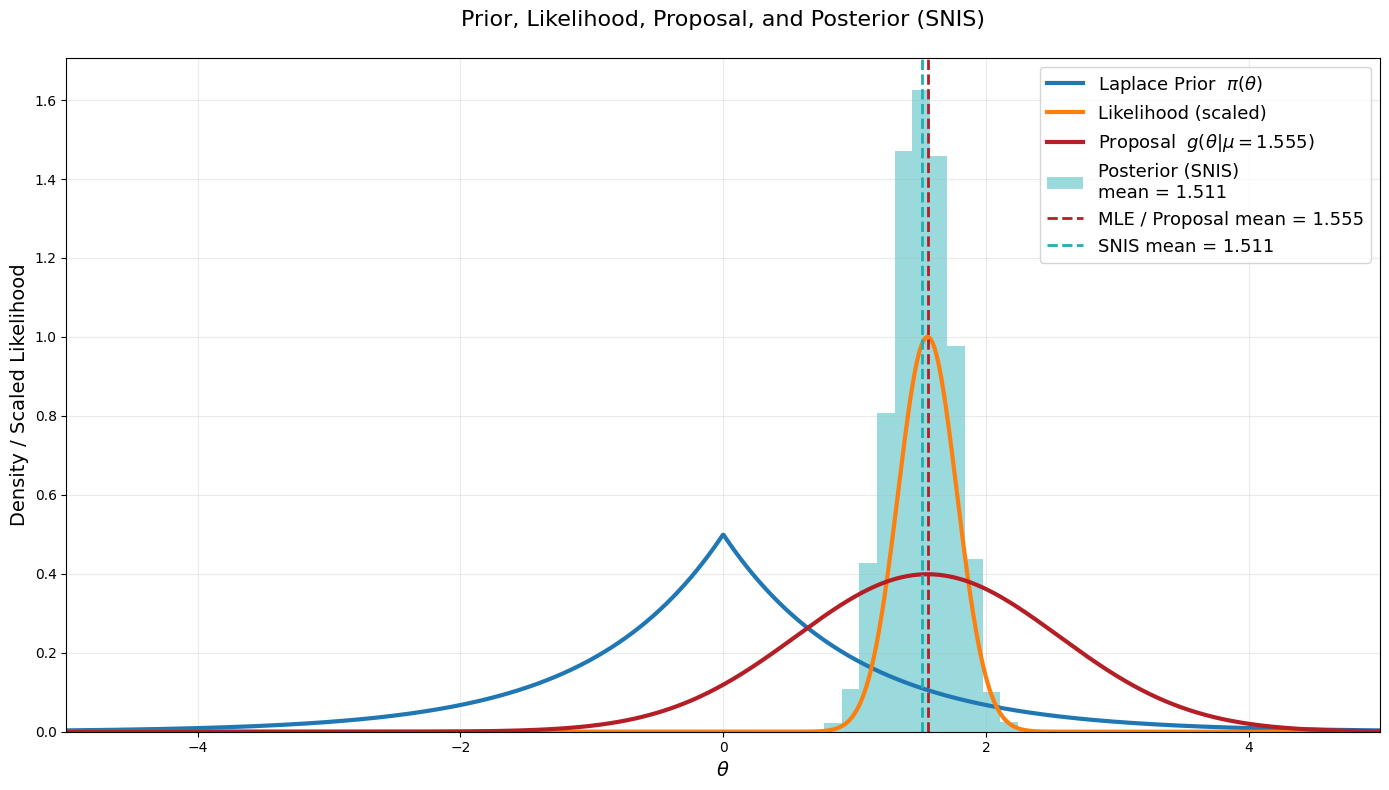

In [11]:
proposal_mu = np.mean(samples_normal)            # MLE = sample mean
snis_mean = mean_is.estimate_snis                # SNIS posterior mean estimate

# θ-grid
x = np.linspace(-5, 5, 2000)

# Prior
prior_pdf = prior_rv.pdf(x)

# Proposal density
prop_pdf_vals = prop_pdf_partial(x)

# Likelihood (unnormalized but scaled)
lik_vals = likelihood_unnormalized(x, samples_normal)
lik_scaled = lik_vals / np.max(lik_vals)

# Posterior (SNIS)
theta_samples = mean_is.x_samples
weights = mean_is.w_norm

# ---- Plot ----
plt.figure(figsize=(14,8))

# Prior
plt.plot(
    x, prior_pdf,
    label="Laplace Prior  $\\pi(\\theta)$",
    linewidth=3,
    color="#1f77b4"
)

# Likelihood (scaled)
plt.plot(
    x, lik_scaled,
    label="Likelihood (scaled)",
    linewidth=3,
    color="#ff7f0e"
)

# Proposal
plt.plot(
    x, prop_pdf_vals,
    label=f"Proposal  $g(\\theta | \\mu = {proposal_mu:.3f})$",
    linewidth=3,
    color="#b41f26"
)

# Posterior estimate via SNIS
plt.hist(
    theta_samples, bins=60,
    weights=weights, density=True,
    alpha=0.45, color="#1fafb4",
    label=f"Posterior (SNIS)\nmean = {snis_mean:.3f}"
)

# Vertical line: MLE (sample mean)
plt.axvline(proposal_mu, color="#b41f26", linestyle="--", linewidth=2,
            label=f"MLE / Proposal mean = {proposal_mu:.3f}")

# Vertical line: SNIS posterior mean
plt.axvline(snis_mean, color="#1fafb4", linestyle="--", linewidth=2,
            label=f"SNIS mean = {snis_mean:.3f}")

plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel("Density / Scaled Likelihood", fontsize=14)
plt.title("Prior, Likelihood, Proposal, and Posterior (SNIS)\n", fontsize=16)
plt.xlim(-5,5)

plt.grid(alpha=0.25)
plt.legend(fontsize=13, frameon=True)
plt.tight_layout()
save_path_2 = os.path.join(ROOT, "images/importance_sampling/Prior_Likelihood_Posterior.png")
plt.savefig(
    save_path_2,
    dpi=300,
    bbox_inches='tight'
)
plt.show()


## Interpretation

Self-normalized importance sampling reconstructs the posterior by
$$
\sum_{i=1}^N \bar{w}_i \delta_{\theta_i},
$$
a weighted empirical distribution that uses normalized weights summing to one.  
Only unnormalized densities are required, and the unknown normalizing constant of the true posterior cancels automatically.

The proposal $g(\theta)$ captures the region of highest likelihood, while the Laplace prior pulls mass toward zero.  
SNIS naturally balances both influences when computing the posterior expectation.

This example demonstrates the essential use of SNIS when the posterior density is known only up to a constant but remains evaluable pointwise.


# Weight Diagnostics: Evaluating Proposal Quality and Posterior Shape

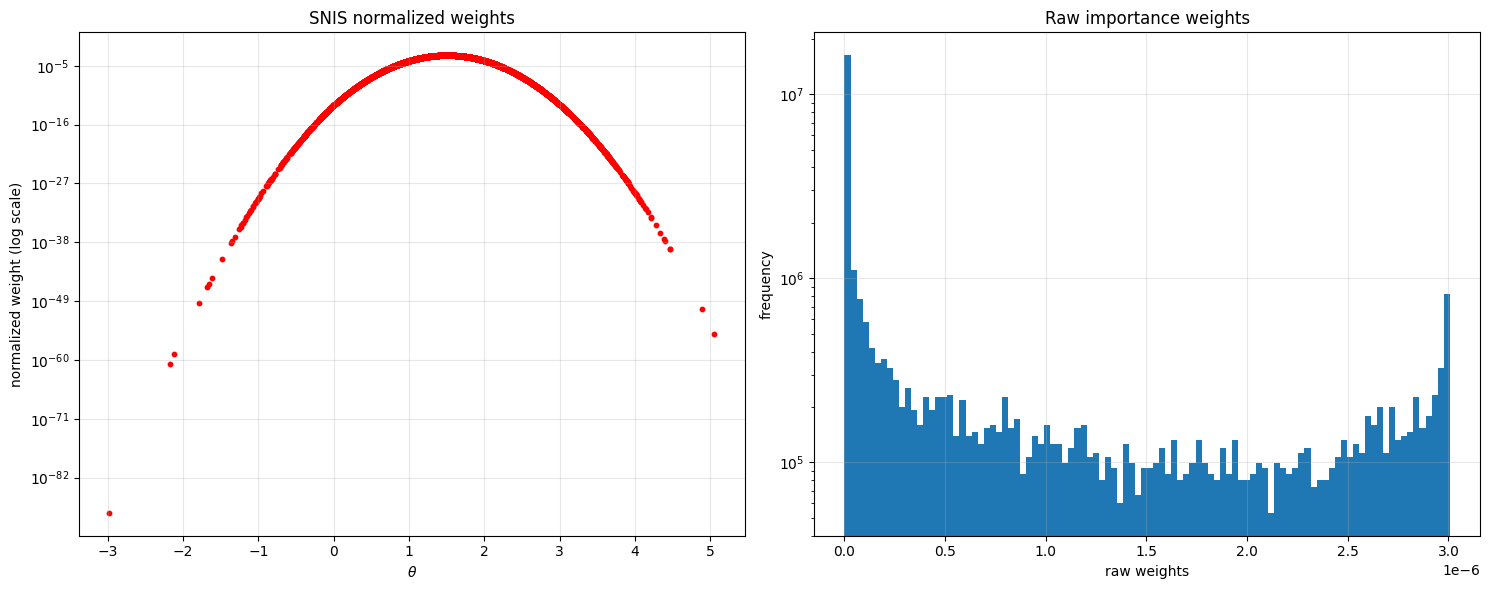

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

# 1) Normalized weights vs theta
ax1.scatter(mean_is.x_samples, mean_is.w_norm, s=10, color="red")
ax1.set_yscale("log")
ax1.set_xlabel(r"$\theta$")
ax1.set_ylabel("normalized weight (log scale)")
ax1.set_title("SNIS normalized weights")
ax1.grid(alpha=0.3)

# 2) histogram of raw weights
ax2.hist(mean_is.w_raw, bins=100, density=True)
ax2.set_yscale('log')
ax2.set_xlabel("raw weights")
ax2.set_ylabel("frequency")
ax2.set_title("Raw importance weights")
ax2.grid(alpha=0.3)

plt.tight_layout()
save_path_3 = os.path.join(ROOT, "images/importance_sampling.png")
plt.savefig(
    save_path_3,
    dpi=300,
    bbox_inches='tight'
)
plt.show()


## Effective Sample Size (ESS) Diagnostic

In [13]:
ess_raw   = mean_is.ess()
ess_norm  = mean_is.ess_normalized()
ess_ratio = ess_norm / num_samples

print(f"n = {num_samples}")
print(f"ESS (raw):        {ess_raw:,.2f}")
print(f"ESS (normalized): {ess_norm:,.2f}  ({ess_ratio*100:.1f}% of samples)")

n = 5000
ESS (raw):        1,546.09
ESS (normalized): 1,546.09  (30.9% of samples)
